In [5]:
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [6]:
# Get and Process the Target Image
target_image_path = cv.imread("target/object.jpg")

target_img = cv.cvtColor(target_image_path, cv.COLOR_BGR2GRAY)

target_img = cv.GaussianBlur(target_img, (3,3), 0)
target_img = cv.equalizeHist(target_img)


In [7]:
# Get All Scene Images
scene_images_path = "images/"
scene_images = []

for file in os.listdir(scene_images_path):
    scene_image_path = os.path.join(scene_images_path, file)
    scene_img = cv.imread(scene_image_path)
    scene_img = cv.cvtColor(scene_img, cv.COLOR_BGR2GRAY)
    scene_img = cv.equalizeHist(scene_img)

    scene_images.append((scene_img, scene_image_path))  # Store the image and its path

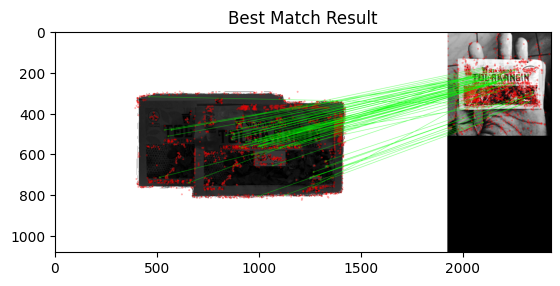

Best matching scene image path: ('images/5.jpg', 2)


In [8]:
# Algorithm -> SIFT, AKAZE, ORB
# Create Object Detection

sift = cv.SIFT_create()
# Detect Features
target_kp, target_ds = sift.detectAndCompute(target_img, None)
target_ds = target_ds.astype('f')

best_match_count = 0
all_mask = []
best_scene_index = -1
best_scene_keypoints = None
best_final_match = None
best_scene_path = None

for idx, (scene_img, scene_image_path) in enumerate(scene_images):
    # Detect Features
    scene_kp, scene_ds = sift.detectAndCompute(scene_img, None)
    scene_ds = scene_ds.astype('f')

    # FLANN
    INDEX_PARAM = dict(algorithm=1)
    SEARCH_PARAM = dict(checks=50)

    flann = cv.FlannBasedMatcher(INDEX_PARAM, SEARCH_PARAM)
    matches = flann.knnMatch(scene_ds, target_ds, 2)

    matches_count = 0
    scene_mask = [[0,0]]*len(matches)

    # create masking -> to filter the good matches.
    for j, (m,n) in enumerate(matches):
        # Lowe Theory
        if m.distance < 0.7*n.distance:
            scene_mask[j] = [1,0]
            matches_count+=1
    all_mask.append(scene_mask)

    if matches_count > best_match_count:
        best_match_count = matches_count
        best_scene_index = idx
        best_scene_keypoints = scene_kp
        best_final_match = matches
        best_scene_path = scene_image_path, 2

result_img = cv.drawMatchesKnn(
    scene_images[best_scene_index][0],
    best_scene_keypoints,
    target_img,
    target_kp,
    best_final_match,
    None,
    matchColor=[0, 255, 0],
    singlePointColor=[255, 0, 0],
    matchesMask=all_mask[best_scene_index]
)

plt.imshow(result_img, cmap='gray')
plt.title("Best Match Result")
plt.show()

# Print the path of the best matching scene image
print("Best matching scene image path:", best_scene_path)